In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20


# Quickstart Tutorial

In [2]:
import coronagraph as cg
print(cg.__version__)

0.0.2


In [3]:
cg.plot_setup.setup()

First, we'll set up the `Telescope`, `Planet`, and `Star` by instantiating them with their default values. 

In [4]:
telescope = cg.Telescope()
print(telescope)

Coronagraph: 
------------
- Telescope observing mode : IFS
- Minimum wavelength (um) : 0.3
- Maximum wavelength (um)  : 2.0
- Spectral resolution (lambda / delta-lambda)  : 70.0 
- Telescope/System temperature (K)  : 260.0 
- Detector temperature (K)  : 50.0 
- Telescope diameter (m)  : 8.0 
- Telescope emissivity  : 0.9 
- Inner Working Angle (lambda/D)  : 0.5 
- Outer Working Angle (lambda/D)  : 30000.0 
- Telescope throughput  : 0.2 
- Raw Contrast  : 1e-10 
- Dark current (s**-1)  : 0.0001 
- Horizontal pixel spread of IFS spectrum  : 3.0 
- Read noise per pixel  : 0.1 
- Maximum exposure time (hr)  : 1.0 
- Size of photometric aperture (lambda/D)  : 0.7 
- Quantum efficiency  : 0.9


In [5]:
planet = cg.Planet()
print(planet)

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 10.0
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 1.0
- Phase angle (deg) : 90.0
- Lambertian phase function : 0.318309886184
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0


In [6]:
star = cg.Star()
print(star)

Star: 
-----
- Effective Temperature (K) : 5780.0
- Radius (Solar Radii) : 1.0


Now let's load in a high resolution model of the Earth's spectrum from [Robinson et al. (2010)](http://adsabs.harvard.edu/abs/2011AsBio..11..393R)

In [7]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

and we can take a look at the disk-integrated geomtric albedo spectrum of the Earth with realistic cloud coverage.

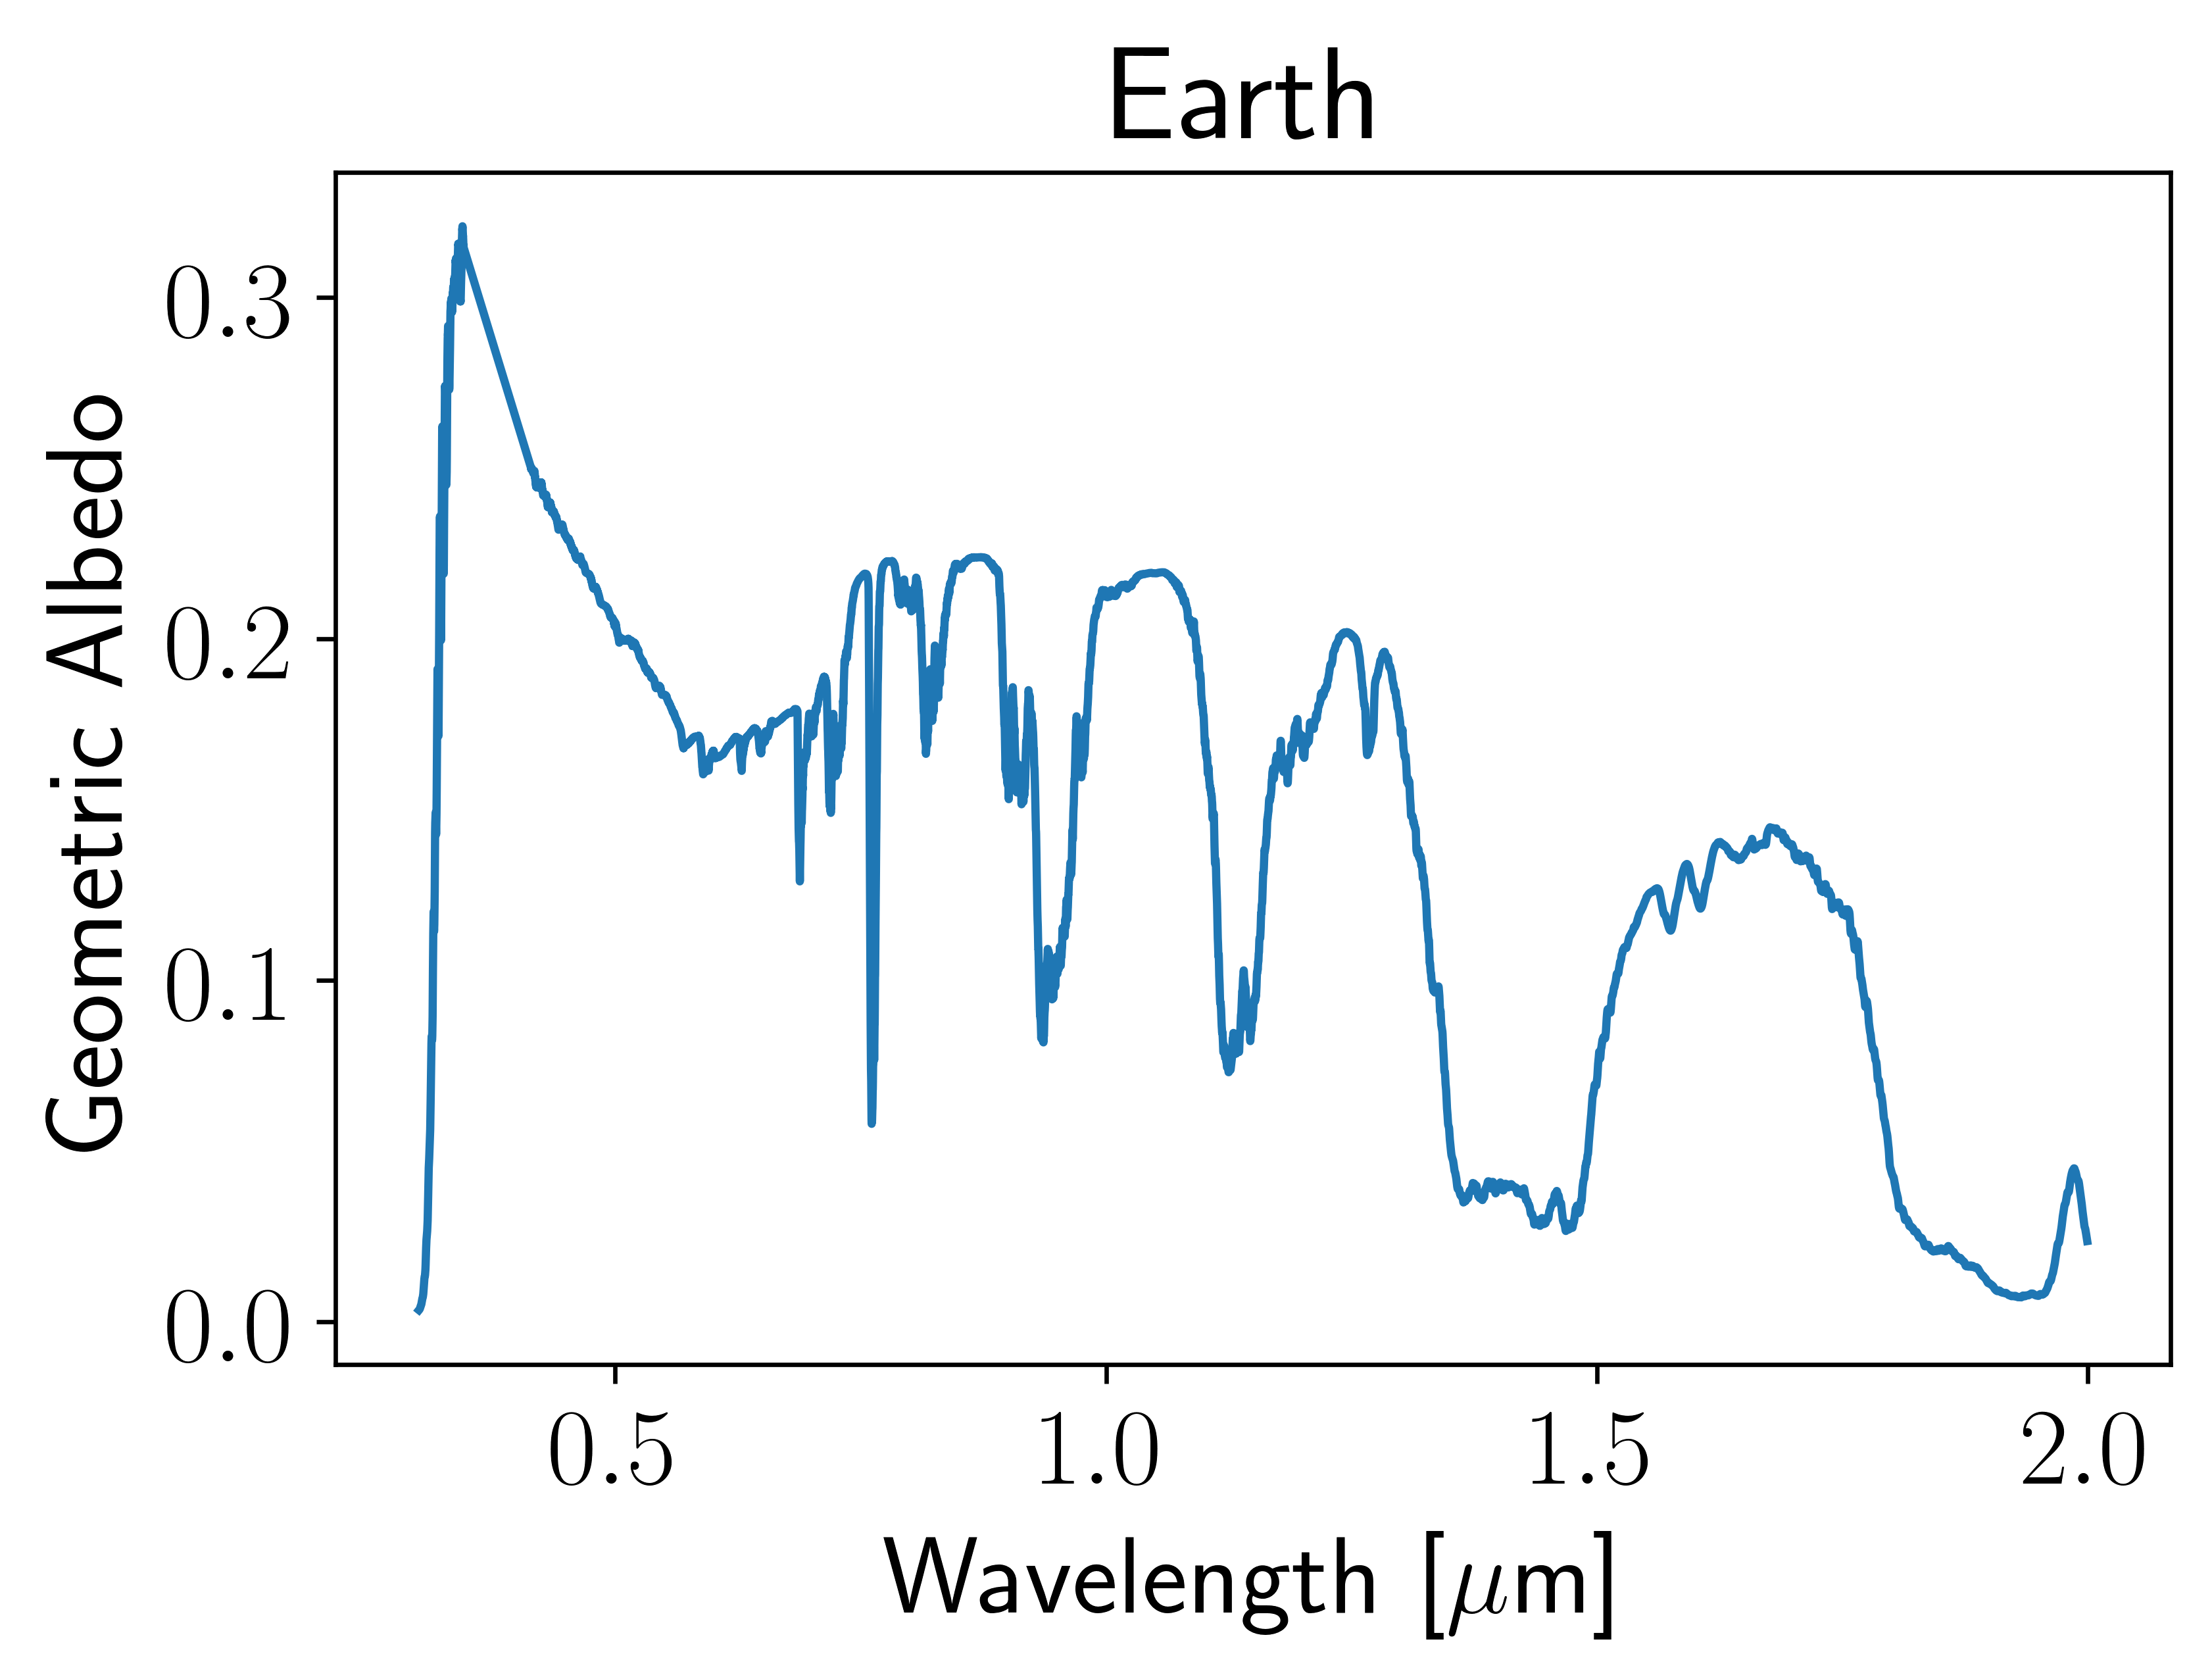

In [8]:
# Create wavelength mask
m = (lamhr > telescope.lammin) & (lamhr < telescope.lammax)

# Plot
plt.plot(lamhr[m], Ahr[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title("Earth");

All we have to do now is calculate the photon count rates incident upon the detector due to the planet and background sources. Just call `count_rates_wrapper` with the spectrum of the planet and star, and initialized `Telescope`, `Planet`, and `Star` objects. 

In [9]:
wantsnr = 10.0
out = cg.count_rates_wrapper(Ahr, lamhr, fstar, telescope, planet, star, wantsnr=wantsnr)

For now let's calculate the background count rate, but in the future this will be done automatically. 

In [10]:
out.cb = (out.cz + out.cez + out.csp + out.cD + out.cR + out.cth)

We can call `process_noise` to sample Gaussian fake data for a given exposure `time`. 

In [11]:
time = 10 # hours
mu, sig, snr = cg.process_noise(time * 60 * 60, out.A, out.cp, out.cb)

The resulting noisey data look like this:

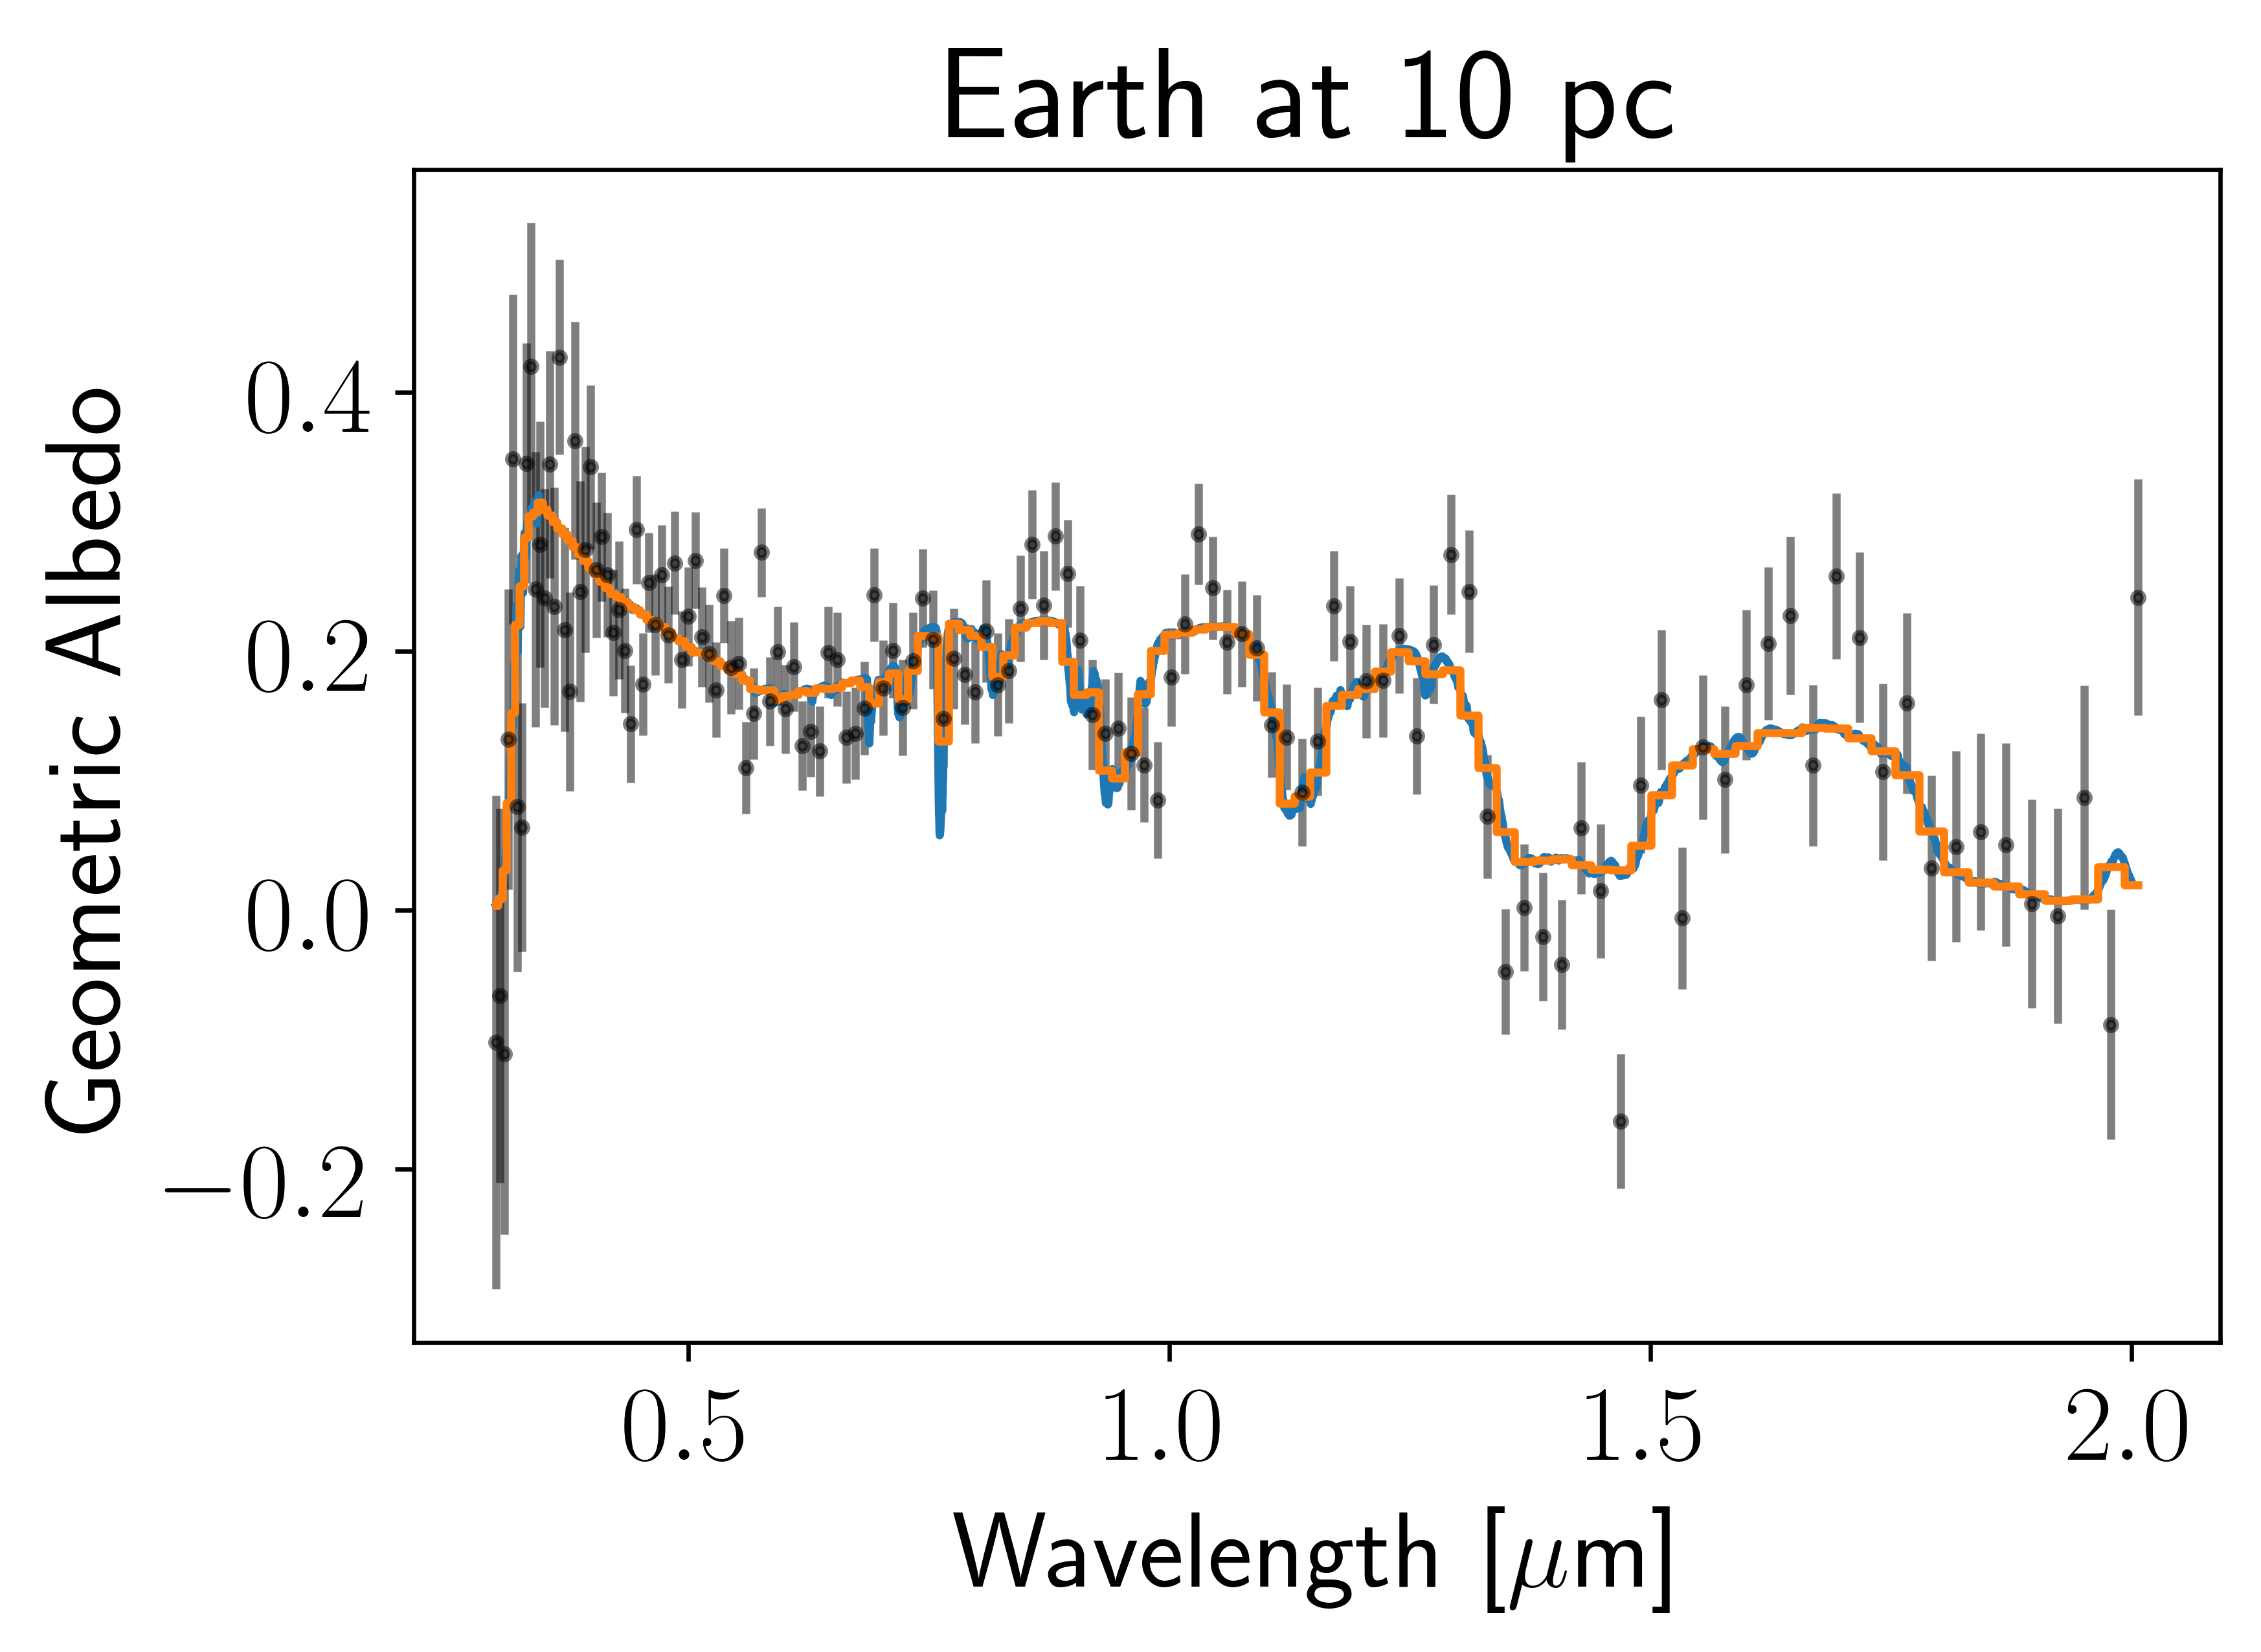

In [12]:
plt.plot(lamhr[m], Ahr[m])
plt.plot(out.lam, out.A, ls = "steps-mid", c = "C1")
plt.errorbar(out.lam, mu, yerr=sig, fmt = "ok", ms = 2, alpha = 0.5)
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title("Earth at %i pc" %planet.distance);

Let's also look at the signal-to-noise ratio in each spectral element.

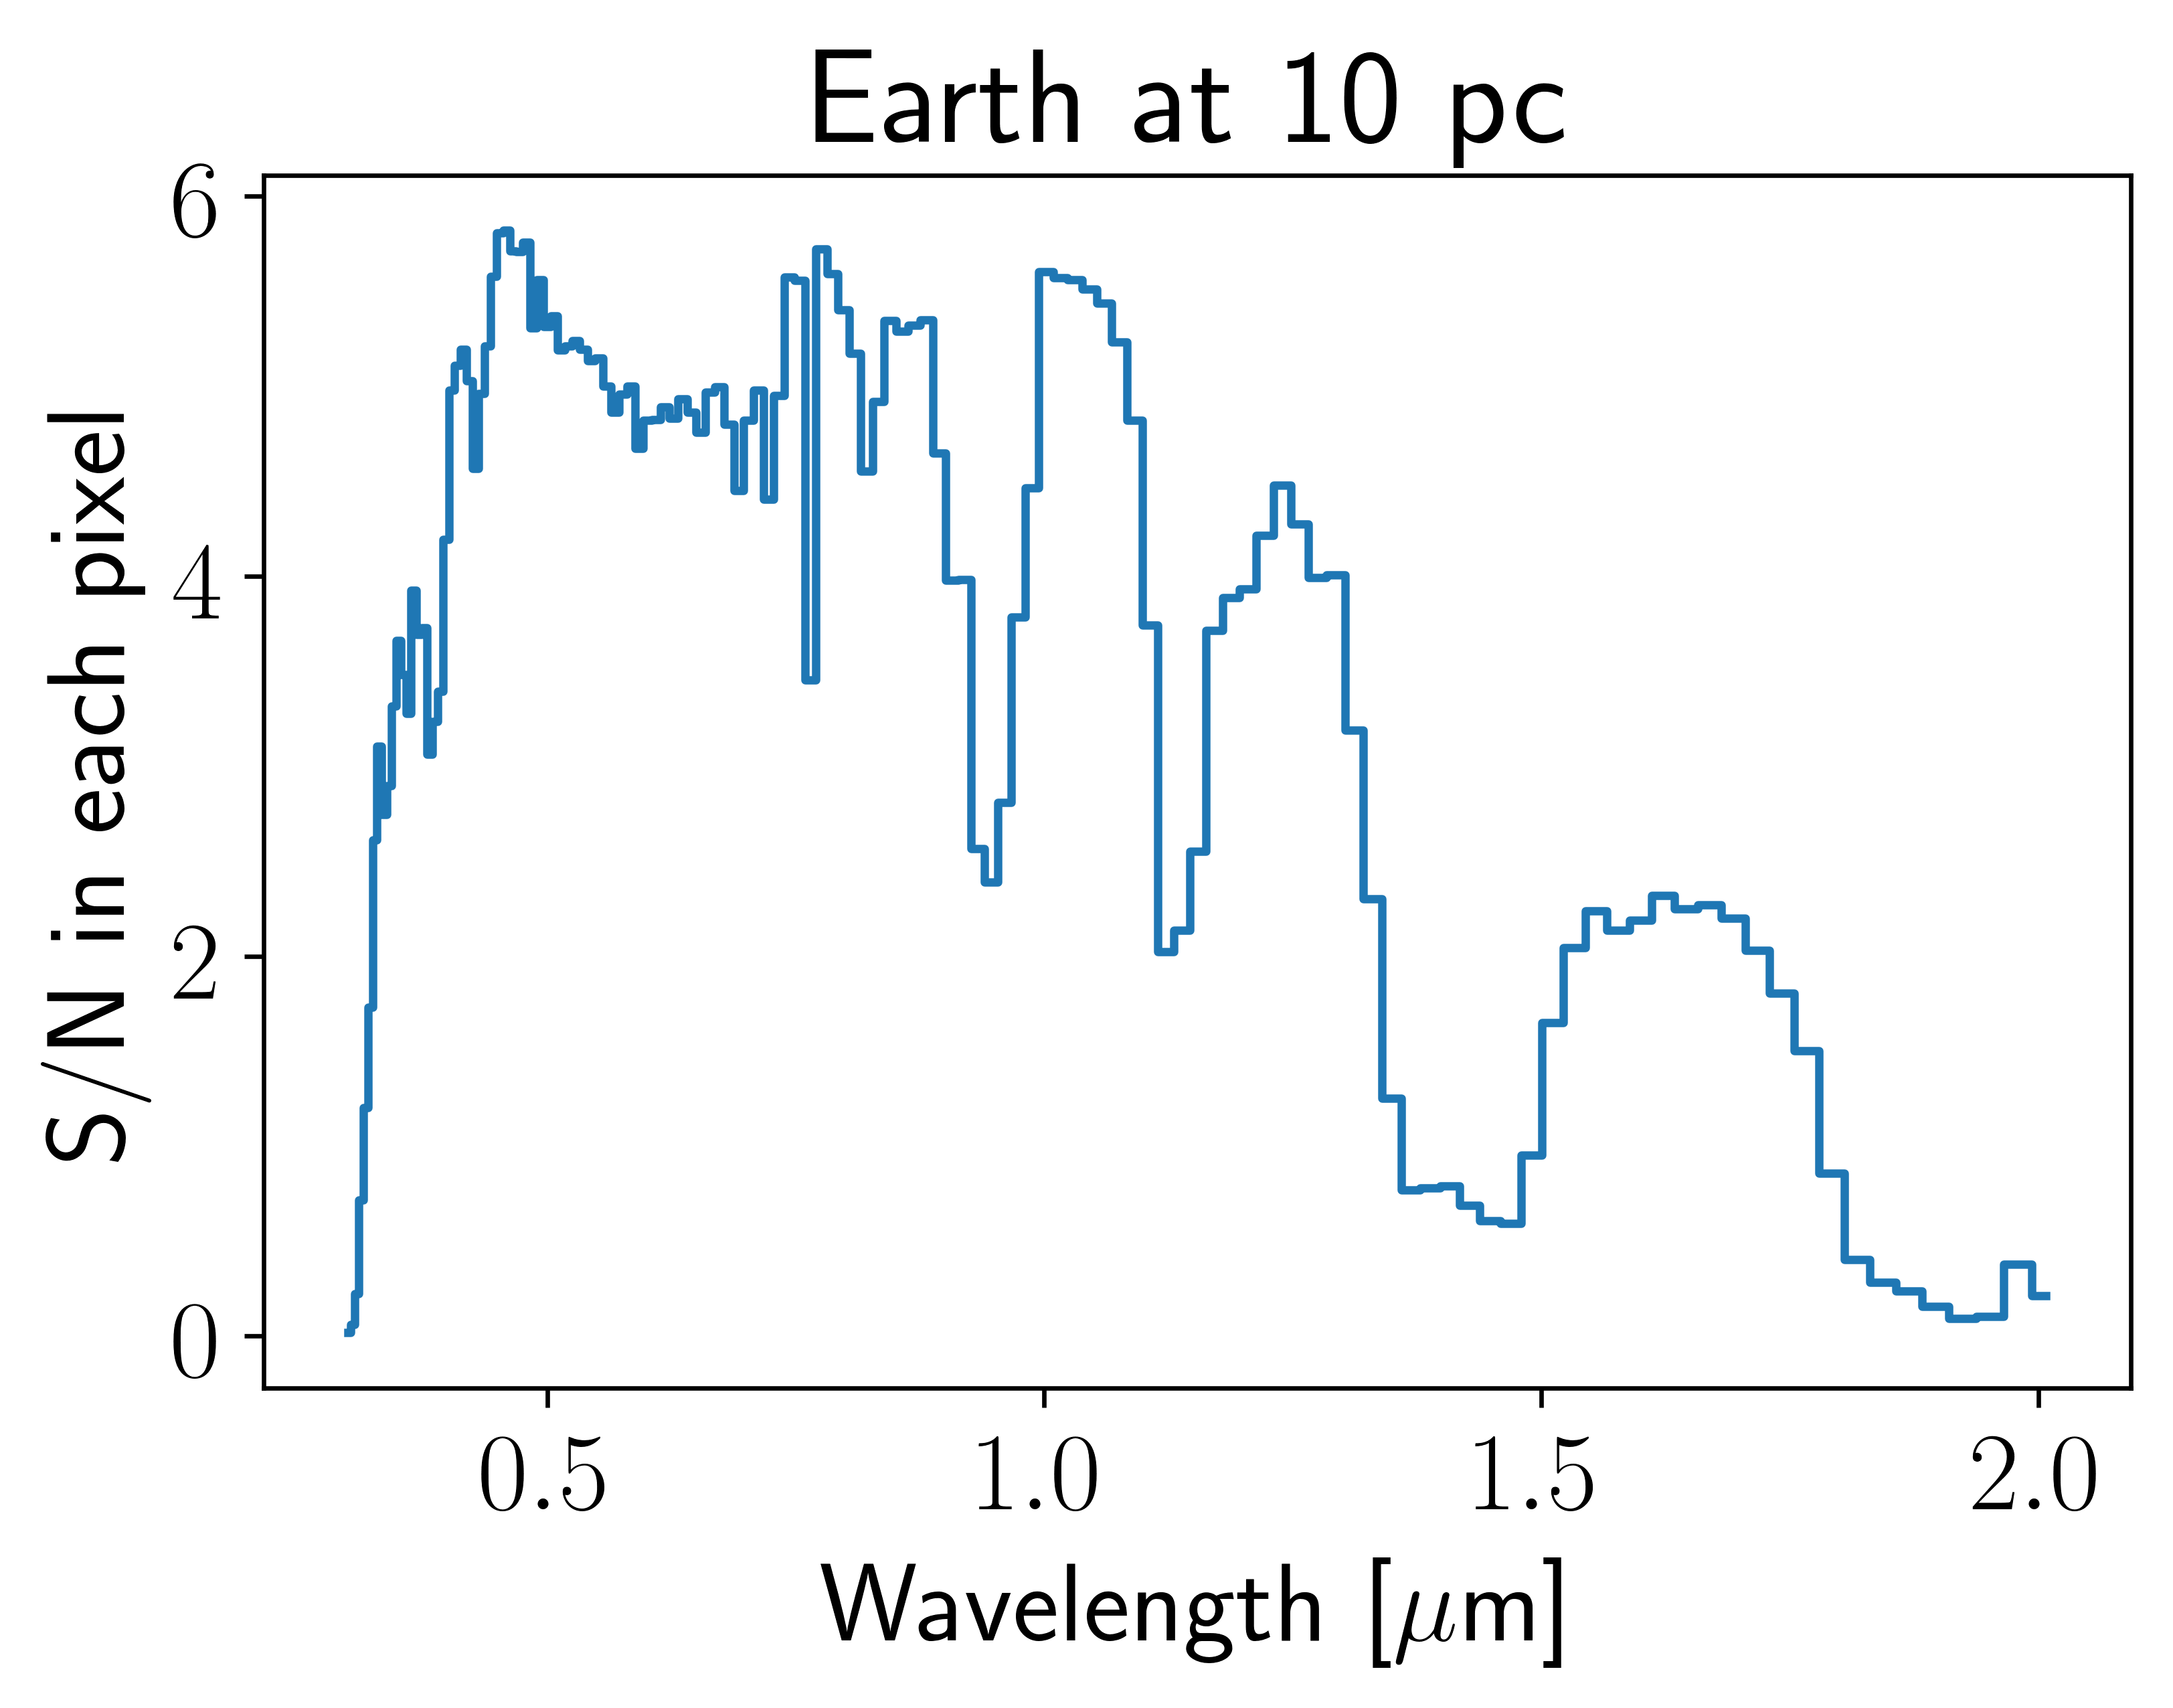

In [13]:
plt.plot(out.lam, snr, ls = "steps-mid")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("S/N in each pixel")
plt.title("Earth at %i pc" %planet.distance);

Finally, let's take a look at the exposure time necessary to achieve a given signal-to-noise ratio (`wantsnr`). 

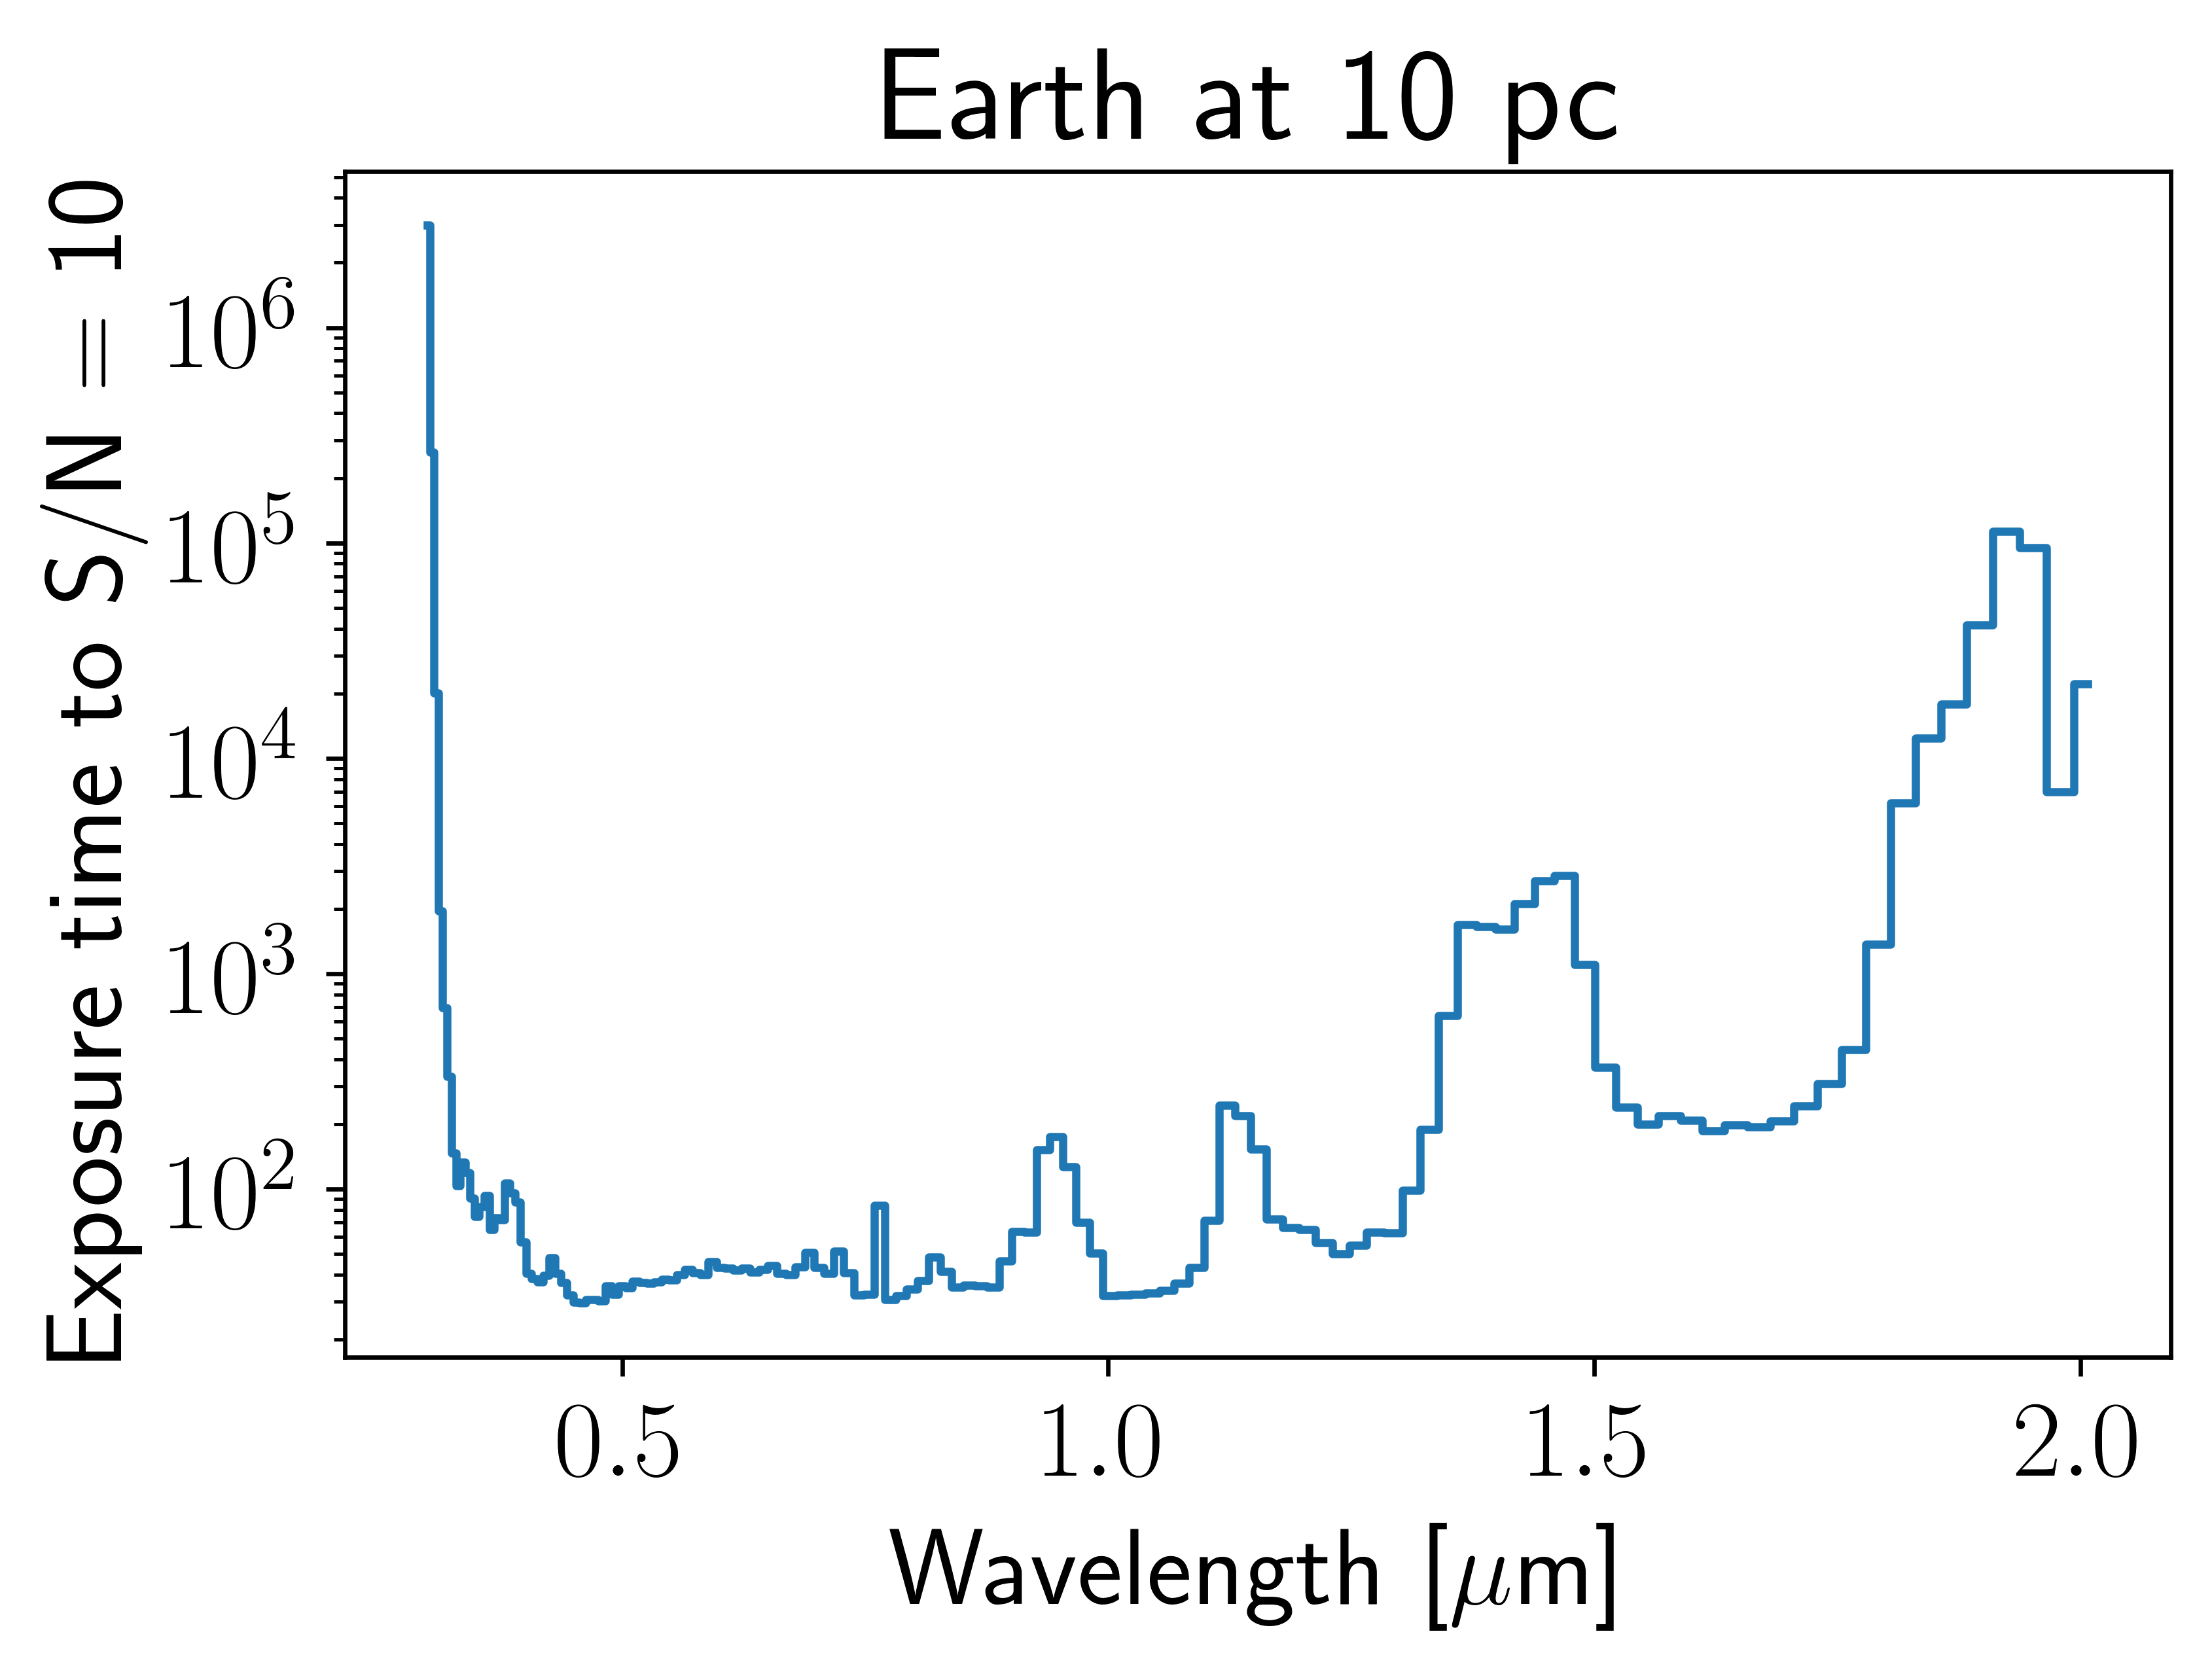

In [14]:
plt.plot(out.lam, out.DtSNR, ls = "steps-mid")
plt.yscale("log")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Exposure time to S/N = %i" %wantsnr)
plt.title("Earth at %i pc" %planet.distance);